## Introduction

[Siamese Networks](https://en.wikipedia.org/wiki/Siamese_neural_network)
are neural networks which share weights between two or more sister networks,
each producing embedding vectors of its respective inputs.

In supervised similarity learning, the networks are then trained to maximize the
contrast (distance) between embeddings of inputs of different classes, while minimizing the distance between
embeddings of similar classes, resulting in embedding spaces that reflect
the class segmentation of the training inputs.

In [1]:
args = dict({
    'dataset_dir': './',
    'dataset_name': 'casia',
    'train_size': 0.667,
    'test_size': 0.333,
    'random_seed': 42,
    'batch_size': 64,
    'margin': 1,
    'epochs': 1000,
    'image_shape': (280, 320, 3)
})

## Setup

## Utils

In [2]:
from sklearn.model_selection import StratifiedShuffleSplit
import glob
import numpy as np
import matplotlib.pyplot as plt

def get_label(path: str, dataset_name: str):
    dataset_split = path.split(dataset_name,1)[1]
    label = int(dataset_split.split('/',2)[1])
    return label - 1

def getDataset(dataset_dir: str, dataset_name: str):
    file_paths = np.sort(glob.glob(dataset_dir + '/*/*.bmp'))
    labels = np.array([get_label(path, dataset_name) for path in file_paths], np.float32)

    return file_paths, labels

def stratifiedSortedSplit(file_paths: np.array, labels: np.array,
                    train_size: float, test_size: float, random_state: int):
    """Splits image paths and labels equally for each class, then sorts them"""
    splitter = StratifiedShuffleSplit(n_splits=1,
                                      train_size=train_size, test_size=test_size, random_state=random_state)
    train_indices, test_indices = next(splitter.split(file_paths, labels))

    files_train, labels_train = file_paths[train_indices], labels[train_indices]
    files_test, labels_test = file_paths[test_indices], labels[test_indices]

    sort_index = np.argsort(labels_train)
    labels_train = labels_train[sort_index]
    files_train = files_train[sort_index]

    sort_index = np.argsort(labels_test)
    labels_test = labels_test[sort_index]
    files_test = files_test[sort_index]

    return files_train, labels_train, files_test, labels_test

def plot_history(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.figure(figsize=(20,4))
  plt.subplot(1,2,1)
  plt.plot(epochs, acc, label='Training accuracy')
  plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
  plt.title('Training and validation acc')
  plt.legend()
  plt.show()

In [3]:
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import random
import keras
import datetime, os

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.manifold import TSNE

tf.random.set_seed(args['random_seed'])
np.random.seed(args['random_seed'])
random.seed(args['random_seed'])
keras.utils.set_random_seed(args['random_seed'])
tf.config.experimental.enable_op_determinism()

2023-08-10 20:26:43.807823: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-10 20:26:43.842379: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-10 20:26:44.334935: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Load the dataset

In [4]:
import os

dataset_path = os.path.join(args['dataset_dir'], args['dataset_name'])

file_paths, labels = getDataset(dataset_path, args['dataset_name'])

## Define training and validation sets

In [ ]:
# Split image paths and labels using Stratified
files_train, labels_train, files_test, labels_test = stratifiedSortedSplit(
    file_paths, labels, args['train_size'], args['test_size'], args['random_seed'])

train_count = np.unique(labels_train, return_counts=True)[1].mean()
test_count = np.unique(labels_test, return_counts=True)[1].mean()
print(
    f'Split {train_count} images from each class for train and {test_count} for test')

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
# from tqdm import tqdm

# Hiperparâmetros
num_classes = len(np.unique(labels))


# Função para carregar as imagens e os rótulos
def carregar_imagens(file_paths, labels, input_shape):
    images = np.empty((len(file_paths),) + input_shape)
    for i in range(len(file_paths)):
      imagem = tf.keras.preprocessing.image.load_img(file_paths[i], target_size=input_shape[:2])
      imagem = tf.keras.preprocessing.image.img_to_array(imagem)
      images[i] = imagem
    return tf.convert_to_tensor(images), tf.convert_to_tensor(labels)

images_train, labels_train = carregar_imagens(files_train, labels_train, args['image_shape'])
# images_train /=  255.0
images_test, labels_test = carregar_imagens(files_test, labels_test, args['image_shape'])
# images_test /=  255.0

# Testing Different Models

In [ ]:
import datetime, os
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K

# create the base pre-trained model

def build_pretrained(pretrained_model, summary=False):
  K.clear_session()
  num_classes = len(np.unique(labels))
  base_model = pretrained_model(weights='imagenet', include_top=False)

  # add a global spatial average pooling layer
  x = base_model.output
  x = GlobalAveragePooling2D()(x)
  # let's add a fully-connected layer
  x = Dense(1024, activation='relu')(x)
  # and a logistic layer -- let's say we have 200 classes
  predictions = Dense(num_classes, activation='softmax')(x)

  # this is the model we will train
  model = Model(inputs=base_model.input, outputs=predictions)

  # first: train only the top layers (which were randomly initialized)
  # i.e. freeze all convolutional InceptionV3 layers
  for layer in base_model.layers:
      layer.trainable = False

  # compile the model (should be done *after* setting layers to non-trainable)
  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  if summary:
    model.summary()

  return model

In [ ]:
model = build_pretrained(EfficientNetB0, False)

In [9]:
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='/tmp/checkpoint',
    save_weights_only=True,
    monitor='val_loss',
    mode='max',
    save_best_only=True)

history = model.fit(
    images_train,
    labels_train,
    validation_data=(images_test, labels_test),
    batch_size=args['batch_size'],
    epochs=args['epochs'],
    callbacks=[checkpoint, tensorboard_callback]
)

Epoch 1/1000


: 

: 

In [ ]:
model.evaluate(images_test, labels_test)

4/4 [==============================] - 1s 133ms/step - loss: 1.8658 - accuracy: 0.7593


[1.8658052682876587, 0.7592592835426331]

In [ ]:
model.save_weights('best_efficient_net_b0.keras')

In [ ]:
model.load_weights('best_efficient_net_b0.keras')

4/4 [==============================] - 55s 149ms/step - loss: 4.7736 - accuracy: 0.0185


[4.773604393005371, 0.018518518656492233]

In [ ]:
model2 = build_pretrained(EfficientNetB0, False)

In [ ]:
model2.load_weights('best_efficient_net_b0.keras')

In [ ]:
model2.evaluate(images_test, labels_test)

4/4 [==============================] - 4s 133ms/step - loss: 1.8658 - accuracy: 0.7593


[1.8658052682876587, 0.7592592835426331]

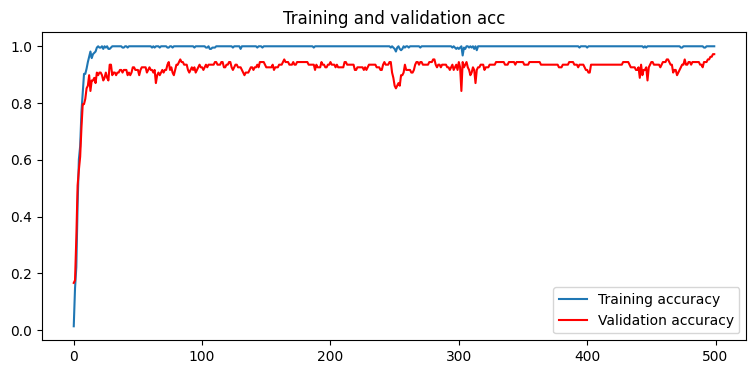

In [ ]:
plot_history(history)

In [ ]:
def run_training(X, y, X_test, y_test, model, plot=False, verbose=0):
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, min_delta=0.005, restore_best_weights=True)
    history = model.fit(X, y, validation_data=(X_test, y_test), epochs=200, verbose=verbose, callbacks=[callback], batch_size = 128)
    if plot:
        plot_history(history)

In [ ]:
!zip -r logs.zip logs

  adding: logs/ (stored 0%)
  adding: logs/20230809-142414/ (stored 0%)
  adding: logs/20230809-142414/validation/ (stored 0%)
  adding: logs/20230809-142414/validation/events.out.tfevents.1691591120.0209fc576c14.429.1.v2 (deflated 68%)
  adding: logs/20230809-142414/train/ (stored 0%)
  adding: logs/20230809-142414/train/events.out.tfevents.1691591054.0209fc576c14.429.0.v2 (deflated 69%)
  adding: logs/20230809-142630/ (stored 0%)
  adding: logs/20230809-142630/validation/ (stored 0%)
  adding: logs/20230809-142630/validation/events.out.tfevents.1691591201.0209fc576c14.429.3.v2 (deflated 81%)
  adding: logs/20230809-142630/train/ (stored 0%)
  adding: logs/20230809-142630/train/events.out.tfevents.1691591190.0209fc576c14.429.2.v2 (deflated 64%)
